In [1]:
from collections import defaultdict
from imblearn.metrics import geometric_mean_score
from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm

from multi_imbalance.ensemble.mrbbagging import MRBBagging
from multi_imbalance.ensemble.ovo import OVO
from multi_imbalance.resampling.mdo import MDO
from multi_imbalance.resampling.soup import SOUP
from multi_imbalance.utils.data import load_datasets_arff
from multi_imbalance.utils.min_int_maj import maj_int_min

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

seed=0
np.random.seed(seed)

sns.set_style('white')
sns.set(rc={'figure.figsize':(12,7)})
sns.set_context("notebook", font_scale=1.5)

In [2]:
datasets = load_datasets_arff(return_non_cat_length=True)

scores = defaultdict(lambda: defaultdict(dict))
datasets_to_compare = ['glass', 'flare', 'new_ecoli', 'new_winequality-red', 'new_yeast', 'balance-scale']
for dataset_name in tqdm(datasets_to_compare):
    dataset_values = datasets[dataset_name]
    X, y = dataset_values.data, dataset_values.target
    non_cat_length = dataset_values.non_cat_length
    for method in ['Tree', 'SOUP', 'MDO', 'OVO', 'MRBB']:
        k_fold_score = list()
        for i in range(10):
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                if non_cat_length > 0:
                    normalizer = StandardScaler().fit(X_train[:, :non_cat_length])
                    X_train[:, :non_cat_length] = normalizer.transform(X_train[:, :non_cat_length])
                    X_test[:, :non_cat_length] = normalizer.transform(X_test[:, :non_cat_length])

                    if method == 'SOUP':
                        soup = SOUP(k=7, maj_int_min=maj_int_min[dataset_name])
                        X_train_resampled, y_train_resampled = soup.fit_transform(np.copy(X_train), np.copy(y_train))
                    elif method == 'MDO':
                        mdo = MDO(k=5, k1_frac=0.4, maj_int_min=maj_int_min[dataset_name], seed=seed)
                        X_train_resampled, y_train_resampled = mdo.fit_transform(np.copy(X_train), np.copy(y_train))
                    else:
                        X_train_resampled, y_train_resampled = X_train, y_train

                    if method == 'OVO':
                        clf = OVO(binary_classifier=DecisionTreeClassifier(random_state=seed),
                                  preprocessing=SOUP(maj_int_min=maj_int_min[dataset_name]))
                    elif method == 'MRBB':
                        clf = MRBBagging(k=100, learning_algorithm=DecisionTreeClassifier())
                    else:
                        clf = DecisionTreeClassifier(random_state=i)

                clf.fit(X_train_resampled, y_train_resampled)
                y_pred = clf.predict(X_test)
                gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
                k_fold_score.append(gmean)

        scores[dataset_name][method] = round(np.mean(k_fold_score), 4)

### Results
G-mean metric

In [3]:
df = pd.DataFrame(scores).T
df.to_csv(f'results.csv')

In [4]:

df = read_csv('results.csv')
df.columns = ['Dataset', 'Baseline', 'SOUP', 'MDO','OVO + SOUP', 'MRBBagging']
df = df.set_index('Dataset').T
df.columns = ['glass', 'flare', 'ecoli', 'winequality-red', 'yeast', 'balance-scale']
df = df.T
df

,Baseline,SOUP,MDO,OVO + SOUP,MRBBagging
glass,0.4506,0.6198,0.5031,0.5108,0.6246
flare,0.4719,0.5513,0.4502,0.5399,0.5533
ecoli,0.7131,0.7359,0.7458,0.7518,0.7974
winequality-red,0.4254,0.4564,0.4271,0.4597,0.5289
yeast,0.2471,0.3673,0.2964,0.3615,0.4627
balance-scale,0.1404,0.6006,0.1470,0.6477,0.6352


In [5]:
df_rank = df.rank(axis=1,ascending=True).astype(int)
df_meanrank = pd.DataFrame(df_rank.mean().sort_values(ascending=False),columns=['Mean ranking (the higher the better)']).round(2)
df_meanrank.index.name = 'Method'
df_meanrank

,Mean ranking (the higher the better)
Method,
MRBBagging,4.83
OVO + SOUP,3.67
SOUP,3.33
MDO,2.00
Baseline,1.17


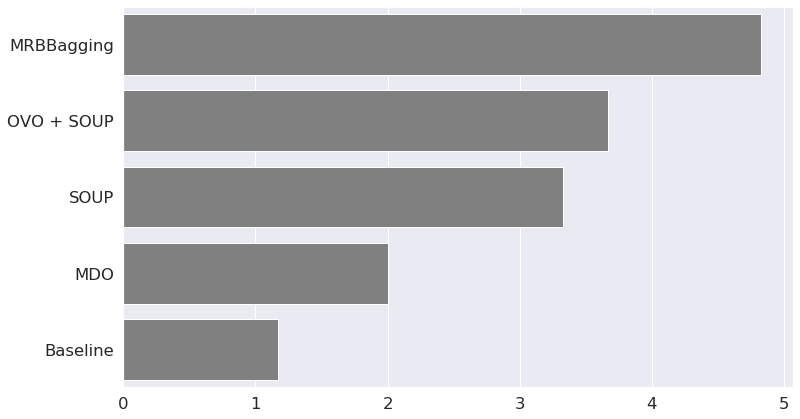

In [6]:
g = sns.barplot(x='Mean ranking (the higher the better)',y=df_meanrank.index, data=df_meanrank, palette=['grey'], dodge=True)
g.set(ylabel=None)
g.set(xlabel=None)
plt.show()